# Graphical Lassoを実装してみよう

元論文: J. Friedman and R. Tibshirani, “Sparse inverse covariance estimation with the graphical lasso,” Biostatistics, pp. 432–441, 2008.

https://academic.oup.com/biostatistics/article/9/3/432/224260

Graphical Lassoを体感するために実際にデータをいじってみましょう.
scikit learnには既に実装されていますので「とりあえずやってみたい！」というのであれば, そちらを使うのが安定です. 
現在numpyによるフルスクラッチでの実装も目論んでいます.

In [1]:
%precision 3
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# display_svgを動かすにはpygraphviz, 並びにgraphvizそのものが必要です.
from IPython.display import display_svg
from sklearn.datasets import make_sparse_spd_matrix, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphLasso
from sklearn.covariance import GraphLassoCV
from sklearn.model_selection import train_test_split
import sklearn
print("sklearnのバージョンは: ", sklearn.__version__)

sklearnのバージョンは:  0.19.0


Graphical Lassoの実装はscikit - learn 0.19.0と0.20では異なっていますのでご注意ください. 関数名が異なっています. [0.20.1でのGraphical Lassoの実装](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.graphical_lasso.html)

## トイデータの作成

In [2]:
def random_mu(dim, a=10):
    """半径aの球上にある点を一つランダムに作る関数"""
    while True:
        x = np.random.randn(dim)
        r = np.linalg.norm(x)
        if r != 0.:
            return a * x/r
        

def diag_to_zero(mat):
    """行列の対角成分を0にしたものを返す関数"""
    G = mat
    for i in range(len(G)):
        for j in range(len(G[i])):
            if i == j:
                G[i][j] = 0
    return G


def describe_graph(lam):
    """Jupyter Notebook上で精度行列からグラフィカルモデルを描画する関数"""
    mat = diag_to_zero(lam)
    G = nx.Graph(mat)
    G.add_nodes_from(range(len(mat)))
    svg = nx.nx_agraph.to_agraph(G).draw(prog='fdp', format='svg')
    display_svg(svg, raw=True)

In [3]:
# データの形は(n, D)
D = 7  # データの次元
n = 1000  # サンプル数
s = 0.80  # スパース性の指定, 0-1の値をとり, 1に近づくほどスパース
mu = random_mu(D)  # 平均は適当に決定
lam = make_sparse_spd_matrix(dim=D, alpha=s)  # スパースな精度行列を生成
cov = np.linalg.inv(lam)  # 関数に渡すため, 分散共分散行列も生成
X = np.random.multivariate_normal(mu, cov, n)  # トイデータを作成

In [4]:
print("mu: ", mu)
print("lambda: \n", lam)
print("cov: \n", cov)
print("データXの形は", X.shape)

mu:  [-4.45055431 -3.36794964 -5.89188461  0.20287805  5.19823011  0.1301865
  2.65621403]
lambda: 
 [[ 1.18737569 -0.43286913  0.          0.          0.          0.
   0.        ]
 [-0.43286913  1.51635806  0.         -0.71858059  0.          0.
   0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.        ]
 [ 0.         -0.71858059  0.          1.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.        ]]
cov: 
 [[1.         0.43286913 0.         0.31105135 0.         0.
  0.        ]
 [0.43286913 1.18737569 0.         0.85322512 0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.31105135 0.85322512 0.         1.613111   0.         0.
  0.        ]
 [0.         0.         0.  

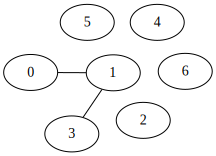

In [5]:
# 今回の精度行列によるグラフィカルモデルを描画してみる
describe_graph(lam)

## IRISデータの読み込み

In [6]:
iris = load_iris()

In [7]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [8]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

- sepal: がく
- petal: 花弁

一つ一つのデータはこの4つの特徴量で指定される4次元のデータになっています.

In [9]:
X_iris = iris.data

In [10]:
X_iris.shape

(150, 4)

全部で150個のデータです. のちに述べますがこのデータはクラスタごとに振る舞いがやや異なるので, そのまま全てのデータが同一の正規分布に従っていると仮定するのは本来は**良くありません**.

In [11]:
X_iris.mean(axis=0)

array([5.84333333, 3.054     , 3.75866667, 1.19866667])

## 最尤推定してみる

データが正規分布に従っていると仮定した上で最尤推定をすると, 分散共分散行列の推定量は標本分散共分散行列$S$で表現されました.
$$ S = \frac{1}{n} \sum_{i}^n (x_i - \bar{x})(x_i - \bar{x})^T$$
これを計算して, さらに逆行列(精度行列)を求め, 最尤推定された精度行列によるグラフィカルモデルを書いてみましょう.

ここでは真の関係性(精度行列)がわかっているトイデータに対してのみ最尤推定を行うことにします.

In [12]:
# numpyによる平均の計算の仕方, axisに注意
X_mean = X.mean(axis=0)
X_mean

array([-4.41571908, -3.40825794, -5.9813464 ,  0.22045258,  5.18709303,
        0.08118152,  2.67199782])

In [13]:
# 平均ベクトルの分だけシフトする操作はこのように書ける.
X_std = X - X_mean
X_std[0:3]

array([[ 0.46537299,  0.48695751, -1.72045246,  0.32350828,  0.22745787,
         0.17493168,  2.12080252],
       [ 0.07787738, -0.04883651, -0.60774492,  0.69708274, -1.52823711,
        -1.28014805, -0.38584495],
       [ 0.62432444, -1.10137756,  0.22243002,  0.19912765, -0.9856038 ,
        -1.24458369,  0.17887137]])

In [97]:
%precision 3
# 行列計算だとこのように標本分散共分散行列は計算できる
S = (1.0 / n) * np.dot(X_std.T, X_std)

# numpyの精度変更
np.set_printoptions(precision=2)
print(S)

[[ 1.07e+00  4.38e-01  2.51e-02  3.34e-01 -4.20e-03  3.72e-02 -2.12e-04]
 [ 4.38e-01  1.19e+00  2.14e-02  8.48e-01  3.23e-02  2.86e-02  1.51e-02]
 [ 2.51e-02  2.14e-02  9.77e-01 -3.73e-02 -1.96e-02 -1.90e-02 -7.04e-02]
 [ 3.34e-01  8.48e-01 -3.73e-02  1.60e+00  5.20e-02  3.62e-02 -1.79e-02]
 [-4.20e-03  3.23e-02 -1.96e-02  5.20e-02  9.92e-01 -1.11e-02 -3.39e-02]
 [ 3.72e-02  2.86e-02 -1.90e-02  3.62e-02 -1.11e-02  1.02e+00  3.65e-02]
 [-2.12e-04  1.51e-02 -7.04e-02 -1.79e-02 -3.39e-02  3.65e-02  9.71e-01]]


In [98]:
# 精度行列は分散共分散行列の逆行列
# これが最尤推定された精度行列
estimated_lam = np.linalg.inv(S)
estimated_lam

array([[ 1.1 , -0.39, -0.02, -0.03,  0.02, -0.03,  0.01],
       [-0.39,  1.48, -0.05, -0.7 , -0.02, -0.  , -0.04],
       [-0.02, -0.05,  1.03,  0.06,  0.02,  0.02,  0.08],
       [-0.03, -0.7 ,  0.06,  1.01, -0.03, -0.02,  0.03],
       [ 0.02, -0.02,  0.02, -0.03,  1.01,  0.01,  0.04],
       [-0.03, -0.  ,  0.02, -0.02,  0.01,  0.98, -0.04],
       [ 0.01, -0.04,  0.08,  0.03,  0.04, -0.04,  1.04]])

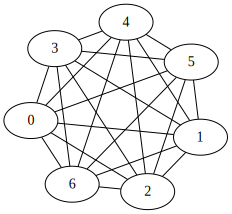

In [16]:
# 最尤推定によるグラフィカルモデル
describe_graph(estimated_lam)

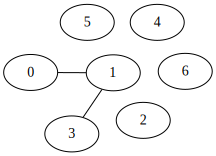

In [17]:
# 真のグラフィカルモデル
describe_graph(lam)

最尤推定を行うと一般に0となる成分は出て来ないため, グラフィカルモデルとしては
どの変数間にも「関係性がある」というような完全グラフになってしまいます.
これでは実態を捉えられていませんし, 何より面白味もありません. そのため, L1正則化をかけながら精度行列を推定していくモチベーションが生まれてきます.

## Graphical Lasso

データ行列$X \in \mathbb{R}^{n \times D}$を受け取って, 疎な精度行列$\Lambda$を推定する関数を作りましょう.

### scikit-learnによる実装

先ほども述べましたがGraphical Lassoの実装はscikit - learn 0.19.0と0.20では異なっていますのでご注意ください. 関数名が異なっています. [0.20.1でのGraphical Lassoの実装](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.graphical_lasso.html)

このバージョンは0.19.0です.

In [18]:
from sklearn.covariance import GraphLasso
from sklearn.covariance import GraphLassoCV

In [99]:
# alphaは正則化項の係数です. ハイパーパラメータですね.
# とりあえず決めうちでやってみるとこうなります.
model = GraphLasso(alpha=0.1)
model.fit(X_std)

GraphLasso(alpha=0.1, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

In [100]:
# Graphical Lassoで推定された精度行列
model.precision_

array([[ 1.03, -0.28, -0.  , -0.02,  0.  , -0.  ,  0.  ],
       [-0.28,  1.26, -0.  , -0.55, -0.  , -0.  , -0.  ],
       [-0.  , -0.  ,  1.02,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.02, -0.55,  0.  ,  0.88, -0.  , -0.  ,  0.  ],
       [ 0.  , -0.  ,  0.  , -0.  ,  1.01,  0.  ,  0.  ],
       [-0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.98, -0.  ],
       [ 0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  1.03]])

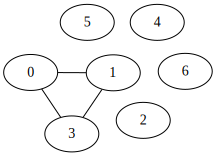

In [101]:
# 推定したグラフィカルモデル
describe_graph(model.precision_)

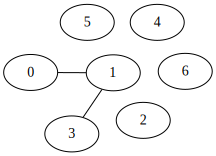

In [22]:
# 真のグラフィカルモデル
describe_graph(lam)

だいぶ近くていい感じですね.

scikit - learnにはGraphLassoCVというCross Validationまでやってくれる便利な関数があるんですが, 各ハイパーパラメータ$\rho$に対応する精度行列は保存されていないので, 自分でモデル選択してみることにします. 

In [23]:
model.score(X)

-inf

In [24]:
X_train, X_test = train_test_split(X)

In [25]:
X_train.shape

(750, 7)

In [26]:
X_test.shape

(250, 7)

In [27]:
rhos = np.linspace(start=0, stop=1, num=51)
rhos

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [28]:
# パラメータをタプルで持つ. (正則化係数(rho), テストデータの対数尤度(score), 推定した精度行列(lam))
params = []
for rho in rhos:
    model = GraphLasso(alpha=rho)
    model.fit(X_train)
    score = model.score(X_test)
    lam = model.precision_
    param = (rho, score, lam)
    params.append(param)

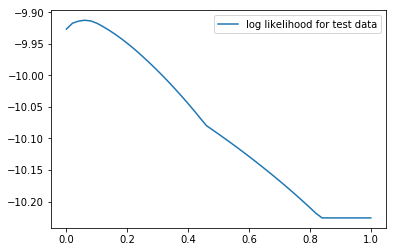

In [29]:
rhos = [param[0] for param in params]
scores = [param[1] for param in params]

plt.plot(rhos, scores, label="log likelihood for test data")
plt.legend()
plt.show()

In [32]:
lams = [param[2] for param in params]

In [33]:
# グラフの移り変わりを記録するコード
# for j, lam in enumerate(lams):
#     mat = diag_to_zero(lam)
#     G = nx.Graph(mat)
#     G.add_nodes_from(range(len(mat)))
#     nx.nx_agraph.to_agraph(G).draw("img/" + str(j) + ".pdf", prog="fdp")

### IRISデータに対してもやってみる

In [162]:
model = GraphLasso(alpha=1)
model.fit(X_iris)

GraphLasso(alpha=1, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

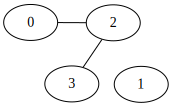

In [163]:
describe_graph(model.precision_)

In [164]:
dic = { 0: "sepal length", 1: "sepal width", 2: "petal length", 3: "petal width" }

In [166]:
dic.values()

dict_values(['sepal length', 'sepal width', 'petal length', 'petal width'])

### フルスクラッチでやってみる

現在開発中です.

In [48]:
def graphical_lasso(X):
    """データX: shape(データ数, データの次元)を受け取って, データXが従うと考えられる正規分布の疎な精度行列と分散共分散行列を返す関数"""
    # データ数
    n = X.shape[0]
    # 一つのデータの次元
    D = X.shape[1]
    
    # 平均を0にシフト
    # 中心極限定理より, データxが正規分布に従っている仮定のもとだと
    # 標本平均を引いたものも真の精度行列と同じ精度行列を持つ正規分布に(nが十分大だと)従う.
    X = X - X.mean(axis=0)
    S = (1.0 / n) * np.dot(X.T, X)